# 03 — Machine Learning baseline on Helmholtz data

Goal: train a small CNN/FNO to map inputs → complex fields and report robust metrics.

We’ll:
1) build a synthetic dataset by solving PDEs,
2) train a tiny model (LocalCNN by default),
3) evaluate rel-L2 (mean/median/p90) + magnitude/phase RMSE,
4) visualize predictions vs targets,
5) (optional) save weights and dataset.


In [1]:
import torch
print(torch.__version__, "CUDA:", torch.cuda.is_available())


2.9.0+cpu CUDA: False


In [2]:
# --- BOOTSTRAP (run first) ---
import os, sys, importlib

PROJECT_ROOT = r"C:\Users\31624\Documents\MIT\Programming\FreqTransfer"
os.chdir(PROJECT_ROOT)

# ensure project root is FIRST so our 'src' wins any name collisions
if PROJECT_ROOT in sys.path:
    sys.path.remove(PROJECT_ROOT)
sys.path.insert(0, PROJECT_ROOT)

print("Python:", sys.executable)
print("CWD   :", os.getcwd())
print("sys.path[0]:", sys.path[0])


Python: c:\Users\31624\Documents\MIT\Programming\FreqTransfer\.venv\Scripts\python.exe
CWD   : C:\Users\31624\Documents\MIT\Programming\FreqTransfer
sys.path[0]: C:\Users\31624\Documents\MIT\Programming\FreqTransfer


In [3]:
import src
importlib.reload(src)          # reload package after edits
print("src file:", src.__file__)

import src.ml as ml
importlib.reload(ml)           # reload ml submodule
print("ml file :", ml.__file__)

# quick capability check
for name in ["build_direct_map", "build_freq_transfer", "LocalCNN", "SimpleFNO", "train_model", "eval_relative_metrics"]:
    print(f"{name:22s} ->", hasattr(ml, name))


src file: C:\Users\31624\Documents\MIT\Programming\FreqTransfer\src\__init__.py
ml file : C:\Users\31624\Documents\MIT\Programming\FreqTransfer\src\ml.py
build_direct_map       -> True
build_freq_transfer    -> True
LocalCNN               -> True
SimpleFNO              -> True
train_model            -> True
eval_relative_metrics  -> True


In [4]:
from src import (
    GridSpec,
    build_direct_map, build_freq_transfer,
    LocalCNN, SimpleFNO,
    train_model, eval_relative_metrics,
)
print("OK")


OK


## Experiment knobs

- `task`: choose **"direct"** (RHS→u) or **"transfer"** (u(ω)→u(ω′)).
- Dataset size is kept small for speed; bump when happy.
- Use **LocalCNN** for quick runs; **SimpleFNO** is slower but stronger.


In [5]:
# --- task selection ---
TASK = "direct"        # "direct" or "transfer"

# --- grid & data ---
grid = GridSpec(2, (48, 48), (1.0, 1.0))
N_SAMPLES = 128        # keep small for quick runs; try 512+ later
K_RANGE = (20.0, 40.0) # for "direct"
OMEGA, OMEGA_P = 25.0, 35.0  # for "transfer"

# --- model ---
MODEL_NAME = "local"   # "local" or "fno"
WIDTH = 48             # channels in the hidden layers

# --- training ---
EPOCHS = 5
BATCH_SIZE = 8
LR = 1e-3
SEED = 0

# --- saving ---
SAVE_DIR = "data/results/03_ml"
os.makedirs(SAVE_DIR, exist_ok=True)


## Build dataset

- **Direct map:** synthesize pairs (RHS[, k]) → solution by assembling and solving.
- **Transfer map:** solve at ω and ω′ with the same RHS, learning u(ω) → u(ω′).


In [6]:
import numpy as np
np.random.seed(SEED)

if TASK == "direct":
    ds = build_direct_map(
        n=N_SAMPLES,
        grid=grid,
        k_range=K_RANGE,
        include_k_channel=True,
        seed=SEED,
        gmres_tol=1e-6,
    )
elif TASK == "transfer":
    ds = build_freq_transfer(
        n=N_SAMPLES,
        grid=grid,
        omega=OMEGA,
        omega_p=OMEGA_P,
        seed=SEED,
        gmres_tol=1e-6,
    )
else:
    raise ValueError("TASK must be 'direct' or 'transfer'")

len(ds), ds[0][0].shape, ds[0][1].shape  # (N, (C_in,H,W), (2,H,W))


(128, torch.Size([3, 48, 48]), torch.Size([2, 48, 48]))

# UNTIL HERE RAN

## Peek at one sample

Check the tensor shapes:
- **Inputs:** channels are `[Re(rhs), Im(rhs), k]` for direct, or `[Re(u_ω), Im(u_ω)]` for transfer.
- **Targets:** `[Re(u), Im(u)]`.


In [7]:
in_ch = ds[0][0].shape[0]
if MODEL_NAME == "local":
    model = LocalCNN(in_ch=in_ch, width=WIDTH)
elif MODEL_NAME == "fno":
    model = SimpleFNO(in_ch=in_ch, width=WIDTH, modes=(12,12), layers=4)
else:
    raise ValueError("MODEL_NAME must be 'local' or 'fno'")

model


LocalCNN(
  (net): Sequential(
    (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): GELU(approximate='none')
    (2): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): GELU(approximate='none')
    (4): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): GELU(approximate='none')
    (6): Conv2d(48, 2, kernel_size=(1, 1), stride=(1, 1))
  )
)

## Train

We use MSE loss on the two output channels `[Re, Im]`.  
A small train/val split monitors overfitting. Keep epochs small until the loop is stable.


In [8]:
model, history = train_model(
    model,
    ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    lr=LR,
    val_split=0.2,
    verbose=True,
)
history


[001/5] train=6.2678e-02  val=1.3214e-03
[002/5] train=1.5599e-03  val=7.5529e-04
[003/5] train=5.0181e-04  val=2.3976e-04
[004/5] train=1.2717e-04  val=6.9152e-05
[005/5] train=5.4759e-05  val=3.3666e-05


{'train': [0.06267751964668815,
  0.0015599480785357838,
  0.000501812621503352,
  0.00012716767546058132,
  5.4758597028782017e-05],
 'val': [0.0013213746133260429,
  0.0007552855531685054,
  0.00023975644580787048,
  6.915242920513265e-05,
  3.366648434166564e-05]}

## Evaluate metrics

We report:
- **rel L2** mean / median / p90 across samples  
- **magnitude RMSE** and **phase RMSE** (phase difference wrapped to \([-π,π]\))


In [9]:
metrics = eval_relative_metrics(model, ds, batch_size=16)
metrics


{'rel_L2_mean': 87.62874202243984,
 'rel_L2_median': 72.09637451171875,
 'rel_L2_p90': 172.41469268798826,
 'mag_RMSE': 0.008842284303106024,
 'phase_RMSE': 1.7997819606196797}

## Visualize predictions vs targets

Pick a few samples and compare magnitude & phase qualitatively.


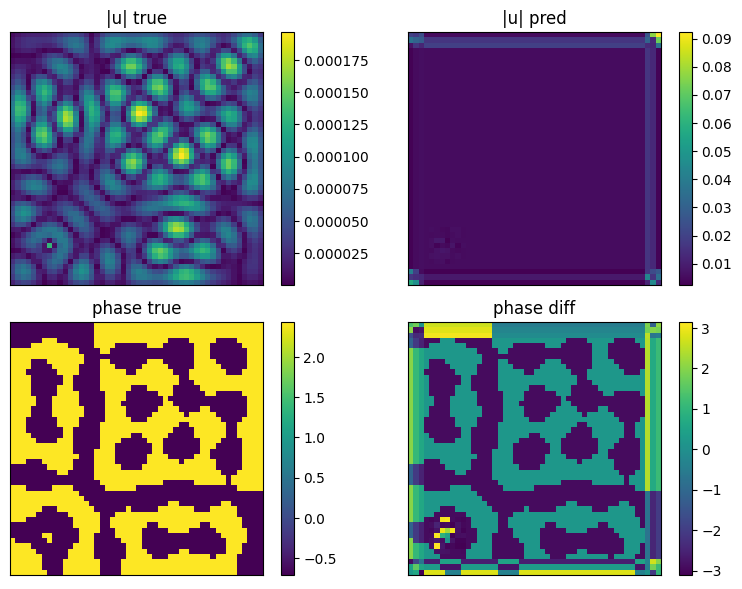

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def show_example(i=0):
    x, y = ds[i]            # tensors
    with torch.no_grad():
        yhat = model(x.unsqueeze(0)).squeeze(0).cpu().numpy()  # (2,H,W)

    yt = y.cpu().numpy()
    def to_complex(twoch): return twoch[0] + 1j*twoch[1]

    u_pred = to_complex(yhat)
    u_true = to_complex(yt)

    fig, axes = plt.subplots(2, 2, figsize=(8,6))
    im0 = axes[0,0].imshow(np.abs(u_true), origin="lower"); axes[0,0].set_title("|u| true"); plt.colorbar(im0, ax=axes[0,0])
    im1 = axes[0,1].imshow(np.abs(u_pred), origin="lower"); axes[0,1].set_title("|u| pred"); plt.colorbar(im1, ax=axes[0,1])
    im2 = axes[1,0].imshow(np.angle(u_true), origin="lower"); axes[1,0].set_title("phase true"); plt.colorbar(im2, ax=axes[1,0])
    # wrap phase diff to [-pi,pi] for a more informative view
    dphi = np.angle(u_pred) - np.angle(u_true)
    dphi = np.angle(np.exp(1j*dphi))
    im3 = axes[1,1].imshow(dphi, origin="lower"); axes[1,1].set_title("phase diff"); plt.colorbar(im3, ax=axes[1,1])
    for ax in axes.ravel(): ax.set_xticks([]); ax.set_yticks([])
    plt.tight_layout()

show_example(i=0)


## Save model & config (optional)

Save trained weights and experiment settings for reproducibility.


In [11]:
torch.save(model.state_dict(), os.path.join(SAVE_DIR, f"{MODEL_NAME}_{TASK}_weights.pt"))
with open(os.path.join(SAVE_DIR, "params.txt"), "w") as f:
    f.write(
        f"TASK={TASK}\nGRID={grid.shape}\nN_SAMPLES={N_SAMPLES}\n"
        f"K_RANGE={K_RANGE}\nOMEGA={OMEGA}, OMEGA_P={OMEGA_P}\n"
        f"MODEL={MODEL_NAME}, WIDTH={WIDTH}\nEPOCHS={EPOCHS}, BATCH={BATCH_SIZE}, LR={LR}\n"
    )
print("Saved to:", SAVE_DIR)


Saved to: data/results/03_ml


## Troubleshooting

- **PyTorch missing:** `pip install torch torchvision` (match your Python and CUDA).
- **Slow dataset build:** reduce `N_SAMPLES`, use smaller grids (e.g., 40×40), or increase GMRES tolerance during data synthesis to `1e-5`/`1e-4` temporarily.
- **OOM during training:** lower `WIDTH`, use `BATCH_SIZE=4`, or switch to `LocalCNN`.
- **Metrics look too good/bad:** visualize a few examples (`show_example(i=...)`) to understand failure modes (phase wrapping, boundary effects, etc.).


In [ ]:
import importlib.util, sys
spec = importlib.util.find_spec("src")
print(spec.origin if spec else "src not found")
